# 0. Постановка задачи
В ходе проекта решается задача минимизации абсолютной ошибки прогнозирования мощности ветряных электростанций, имея 4 характеристики ветра. Данные взяты из [соревнования](https://datascience.totalenergies.com/fr/challenge/19/details#tab_brief84). В связи с тем, что в соревонвании отсутсвуют ответы на test датасет, будем разделять train датасет на train и test. Конечной целью этого исследования является нахождения оптимальных признаков и сохранения модели, для использования их в приложении, принимающем необработанный датасет и генерирующим датасет с предсказаниями. 

# 1. Описание набора данных и признаков
Датасет содержит 18756 записей, для кадой из которых задано 4 признака  и 1 целевую перемнную. Каждая запись представляет собой временной штамп измерения мощности ветра и 4 характеристики ветра вокруг фермы.  
Целевая перменная:
- wp1 - (wind power) нормализованная мощность, вырабатываемая одной ветряной электростанцией. Взаимосвязанна со скоростью ветра;
$$ wp = \frac{ws³*d²*ξ}{2080} $$


Рассмотрим по порядку все имеющиеся признаки:

1) u - зональная составляющая вектора ветра, отрицательное значение характеризует движение ветра на запад, а положительное на восток. Связана со скоростью ветра;
$$ u = cos(\alpha)*ws $$
2) v - меридиональная составляющая вектора ветра, отрицательное значение характеризует движение ветра на север, а положительное на юг. Взаимосвязана со скоростью ветра;  
$$v = sin(\alpha)*ws $$
3) ws -(wind speed) скорость ветра;    
4) wd - направление ветра, угол между вектором ветра и севером, изменяется в пределах 1° - 360°. Взаимосвязана с  u/v;
$$ wd = \alpha - 90° $$


train_phase_1.csv - обучайщий датасет

# 2. Библиотеки 

In [347]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
from scipy.stats import shapiro, kstest
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet 
from catboost import CatBoostRegressor
import pickle
from sklearn.compose import TransformedTargetRegressor

# 3. Очистка данных

In [3]:
SEED = 1

Загрузим данные из файла и зададим параметры вывода датафрейма, чтобы все колонки было видно:

In [325]:
train_df = pd.read_csv('/home/fil/Datasets/wind_prediction/train_phase_1.csv',sep=',')

In [5]:
train_df.head()

,date,wp1,u,v,ws,wd
0,2009-07-01 01:00:00,0.085,2.34,-0.79,2.47,108.68
1,2009-07-01 02:00:00,0.020,2.18,-0.99,2.40,114.31
2,2009-07-01 03:00:00,0.060,2.20,-1.21,2.51,118.71
3,2009-07-01 04:00:00,0.045,2.35,-1.40,2.73,120.86
4,2009-07-01 05:00:00,0.035,2.53,-1.47,2.93,120.13


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18756 entries, 0 to 18755
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    18756 non-null  object 
 1   wp1     18756 non-null  float64
 2   u       18756 non-null  float64
 3   v       18756 non-null  float64
 4   ws      18756 non-null  float64
 5   wd      18756 non-null  float64
dtypes: float64(5), object(1)
memory usage: 879.3+ KB


In [7]:
train_df.isnull().sum()

date    0
wp1     0
u       0
v       0
ws      0
wd      0
dtype: int64

Как видим, данные полные , отсутствуют пропуски , заполнять пропуски нет необходимости.  
Далее проверим данные на выбросы. Для начала сравним минимальное и максимальное значение со средним:

In [8]:
train_df.describe()

,wp1,u,v,ws,wd
count,18756.000000,18756.000000,18756.000000,18756.000000,18756.000000
mean,0.252399,1.670268,-0.187643,4.113137,145.193925
std,0.246383,3.052890,2.898464,1.904632,91.961707
min,0.000000,-9.240000,-10.850000,0.060000,0.020000
25%,0.050000,-0.400000,-2.340000,2.810000,74.710000
50%,0.175000,1.960000,-0.280000,3.710000,123.570000
75%,0.381000,3.640000,1.970000,5.150000,194.830000
max,0.947000,13.270000,10.340000,13.890000,359.920000


Максимальные значения признаков сильно отличаются от их средних. Для дальнейшего анализа построим гистограммы частот признаков и целевой переменной:

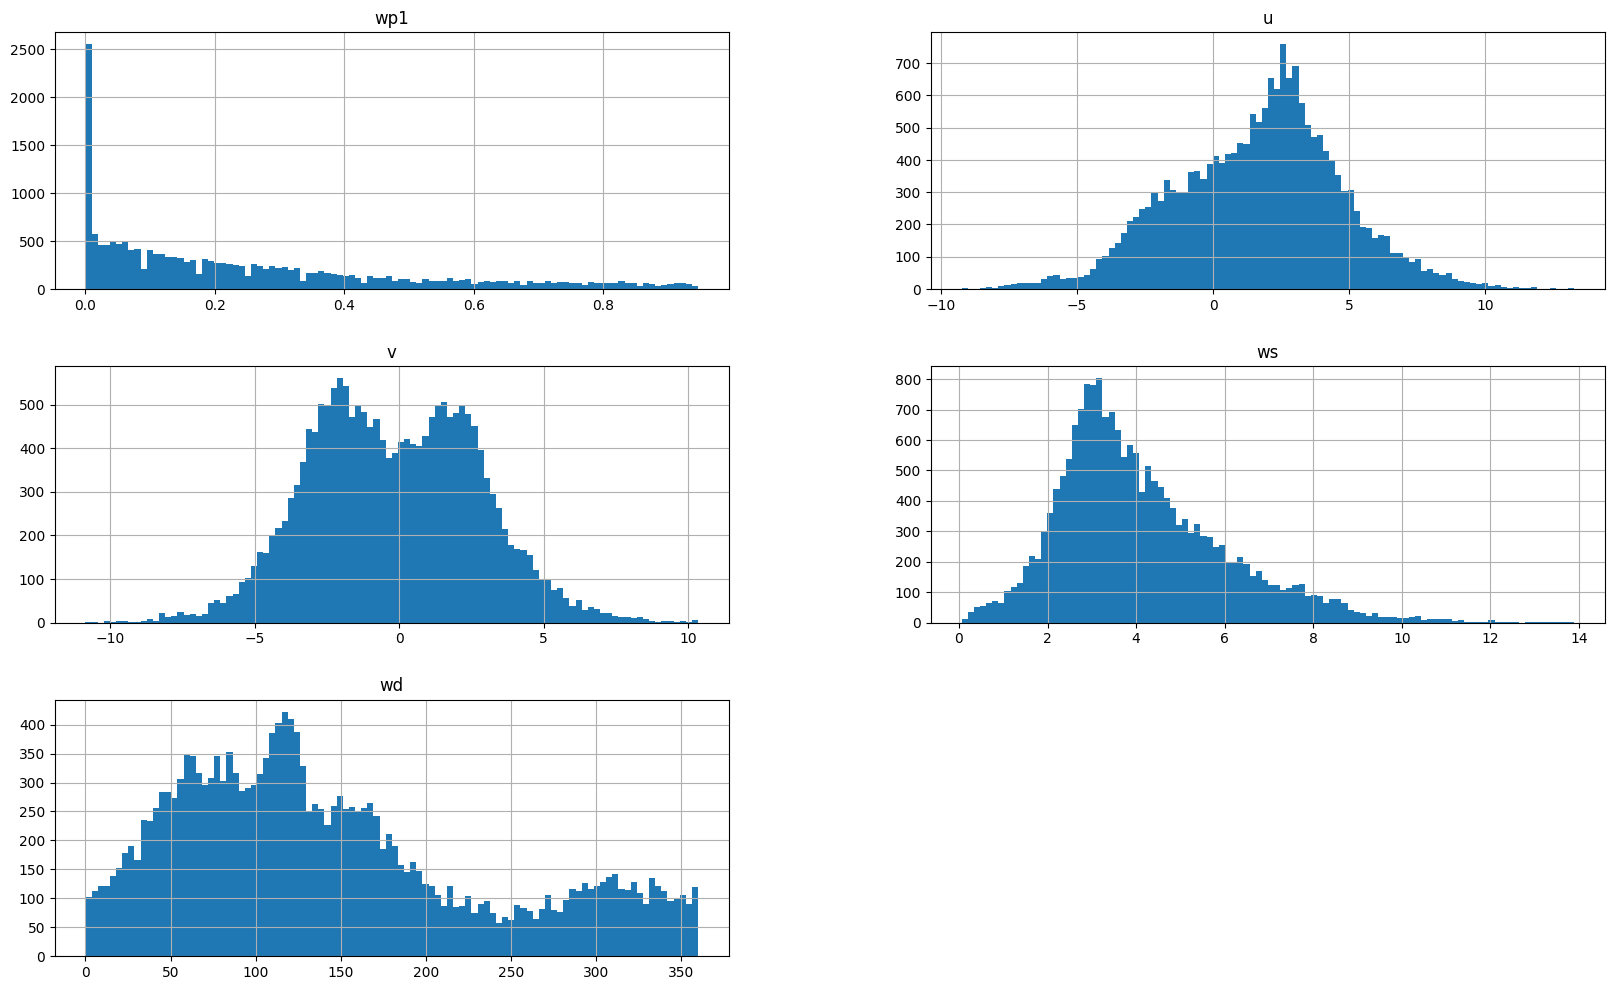

In [9]:
train_df[train_df.columns[1:]].hist(figsize=(20,12), bins=100);

Из вузального анализа видно, что хвосты признаков сильно растянуты. Это потверждает предположение о выбросах в данных. Создадим функцию удаляющую все значения в данных интервалах:
- Ниже первого квартиля − (1.5 - 3.0) ∗ интерквартильный размах  
- Выше третьего квартиля + (1.5 - 3.0) ∗ интерквартильный размах

Создадим функцию range() для float значений:

In [10]:
def frange(start, stop, step):
    i = start
    while i <= stop:
        yield i
        i += step

In [328]:
for interval in np.arange(1.5, 3.5, 0.5):
    train_treshold = round(train_df.shape[0] * 0.7)
    train = train_df[:train_treshold]
    test = train_df[train_treshold:]
    lin_reg = LinearRegression()
    lin_reg.fit(train.iloc[:,2:], train.wp1)
    # МАЕ до удаления данных
    test_0 = mean_absolute_error(test.wp1, lin_reg.predict(test.iloc[:,2:]))
    scale = StandardScaler()
    scale_data =  scale.fit_transform(train.iloc[:,1:])
    sum_scale_data = np.zeros(train.shape[0])
    for column in range(5):
        sum_scale_data += scale_data[:,column]
    sum_scale_data = pd.DataFrame(sum_scale_data, columns=['value'])
    sum_scale_data_quantille = sum_scale_data[(sum_scale_data.value > (sum_scale_data.value.quantile(0.25) - (sum_scale_data.value.quantile(0.75) - sum_scale_data.value.quantile(0.25)) * interval))
                   &
                  (sum_scale_data.value < (sum_scale_data.value.quantile(0.75) + (sum_scale_data.value.quantile(0.75) - sum_scale_data.value.quantile(0.25)) * interval))]
    # процент удаления данных
    data_percent = (sum_scale_data.shape[0] - sum_scale_data_quantille.shape[0]) / sum_scale_data.shape[0] * 100
    new_data = sum_scale_data_quantille.set_index(pd.Series(np.arange(sum_scale_data_quantille.shape[0]))).join(train.set_index(pd.Series(np.arange(train.shape[0])))).drop('value', axis=1)
    lin_reg.fit(new_data.iloc[:,2:], new_data.wp1)
    # МАЕ после удаления данных
    test_1 = mean_absolute_error(test.wp1, lin_reg.predict(test.iloc[:,2:]))
    print('Интервал = {}, Удаляемый процент данных = {}, MAE = {}'.format(interval,
                                                                          round(data_percent, 1),
                                                                          (test_0 - test_1)*100))


Интервал = 1.5, Удаляемый процент данных = 2.9, MAE = -0.0004048362196251709
Интервал = 2.0, Удаляемый процент данных = 1.1, MAE = -0.005870198815455252
Интервал = 2.5, Удаляемый процент данных = 0.4, MAE = 0.0010527040146507405
Интервал = 3.0, Удаляемый процент данных = 0.1, MAE = 0.0011128135584265175


В ходе эксперемента на тестовой выборке оказалось, что максимальное удаление в 0.4 % от общего количества контрольной выборки, дало почти максимальный результат в улучшении МАЕ на 0.001. На основе этого я делаю вывод, что не имеет смысла удаление выборосов , для достижения мнимых результатов.


Посмторим на матрицу корреляции и для удобства визуализируем её:

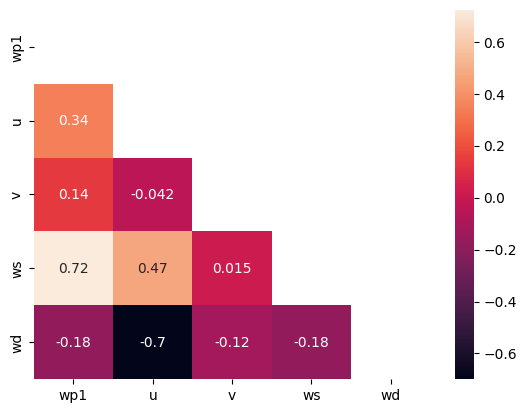

In [12]:
sns.heatmap(train_df.corr(), 
            annot=True, 
            mask=np.triu(np.ones_like(train_df.corr())));

Матрица корреляций отражает, что больше всего коррелируют между собой признаки ws и wp, u и ws, а также u и wd.  
Взаимосвязь ws и wp, отражается в формуле мощности ветрогенератора wp = ws³ * d² * ξ/2080, из чего выходит логичное объяснение , что чем выше скорость ветра тем выше мощность ветрогенератора.  
Взаимосвязь u c ws/wd  видна из формулы u = ws * cos(θ), где θ = wd - 90. Из этого можно предположить, что на данном участке , где стоит ветрогенератор, скорость ветра линейно увеличивается, при движении, с запада на восток. Обратная корреляция u и wd  объясняется , тем что при увеличении u уменьшается угол направления ветра относительно севера.  
В связи с малым количеством первоначальных признаков, на данном этапе, коррелирующие между собой призанки удалять не будем.

Для удобной работы с временными промежутками переведем признак date в формат datetime:

In [13]:
train_df['date'] = pd.to_datetime(train_df.date)

# 4. Выбор метрики и моделей

Оценку результата будем проводить на 10 кратной кроссвалидации. На каждом этапе будем вычислять предложенную в соревновании метрику МАЕ, и по итогу 10 фолдов будем вычислять среднее МАЕ и сренднеквадратическое отклонение между ними. 

$$ MAE =(1/N)\sum_{i=0}^{N}{|y_i-y_i ^` |} $$ 

$$ std = \sqrt{\varepsilon[(X-\varepsilon[X])^2]}  $$

В качестве моделей я хочу исследовать **RandomForest**, **LinnearRegression** и **CatBoost**. Все три модели хорошо справятся с разрозненными данными, но ставку буду ставить на CatBoost.

# 5. Первый  Baseline

Как было описано мною выше, у нас отсутсвуют test данные, и нет возмможности исследовать целевой признак. Для решения этой проблемы , разделим датасет на train_df_new и test_df в пропорции 70/30. Это разделение необходимо для создания первичного baseline , исследования целевого признака и финального выбора моделей.

In [14]:
treshold = round(train_df.shape[0]*0.7) # граница разбиений на train/test

test_df = train_df[treshold:]
train_df_new = train_df[:treshold]

Проведем первичный Baseline на всех моделях , для дальнейших сравнений:

In [15]:
reg = LinearRegression()
reg.fit(train_df_new.iloc[:,2:], train_df_new.wp1)
print('LinearRegression = {}'.format(mean_absolute_error(reg.predict(test_df.iloc[:,2:]), test_df.wp1)))

randforest = RandomForestRegressor(random_state=SEED)
randforest.fit(train_df_new.iloc[:,2:], train_df_new.wp1)
print('RandomForest = {}'.format(mean_absolute_error(randforest.predict(test_df.iloc[:,2:]), test_df.wp1)))

cat = CatBoostRegressor(verbose=False, random_seed=SEED)
cat.fit(train_df_new.iloc[:,2:], train_df_new.wp1)
print('CatBoost = {}'.format(mean_absolute_error(cat.predict(test_df.iloc[:,2:]), test_df.wp1)))

LinearRegression = 0.13663065082707007
RandomForest = 0.14299240776612762
CatBoost = 0.13601877426389936


CatBoost показал самый лучший результат, его мы и будем использовать для оценки признаков на кросс-валидации. 

Напишем функнции для вызова CatBoost с текущим МАЕ и визуализируем влияние признаков для оценки промежуточных результатов:

Используя атрибут **feature_importance_** функции sklearn.ensemble.RandomForestRegressor 

In [16]:
class Model_score():
    
    def __init__(self, model: str):
        """
        self.max_score (float): Обновляемое значение лучшего МАЕ;
        model (str): Выбор модели - [cat, lin, forest];
        
        df_feature_importance (pd.DataFrame): DataFame feature importance
        feature_importance_values (pd.DataFame): DataFame с значениями МАЕ в зависимости от границы разбияния признаков
        """
        self.max_score = 1.0
        self.model = model
        self.df_feature_importance = pd.DataFrame()
        self.feature_importance_values = pd.DataFrame({'treshold':[],
                                                        'best_mae':[]})
        self.lin_reg_best_iteration_feature_importance = {}
        
    def score(self,
            X: pd.DataFrame,
            cat_features: List[str]=None,
            is_print: bool=True,
            y: pd.Series = train_df.wp1
                           ) -> str:
        """
        Функция расчитывает МАЕ с текущими признаками и показывает разницу

        params:
        X (pd.DataFrame): данные с фичами и таргетом;
        y (pd.Series): целевая пременная Deafult train_df.wp1
        cat_features (List[str]): категориальные фичи. Defaults to None;
        is_print (bool): Вывести как str с сравнением или как float. Default True;
        return str: ...
        """
        #y = train_df.wp1
        
        if ("date" or 'wp1') in X.columns:
            X = X.drop(['date','wp1'], axis=1)
        
        if self.model == 'cat':
            reg = CatBoostRegressor(random_seed=SEED,  verbose=False)
            reg.fit(X, y, cat_features=cat_features, verbose=False)
        
        elif self.model == 'lin':
            reg = LinearRegression()
            reg.fit(X, y)
         
        elif self.model == 'forest':
            reg = RandomForestRegressor(random_state=SEED, n_jobs=-1)
            reg.fit(X, y)
            
        score = cross_validate(reg, X, y, cv=5, 
                               scoring=('neg_mean_absolute_error'))['test_score']
        if is_print == True:
            if abs(score.mean()) < self.max_score:
                old_score = self.max_score
                self.max_score = abs(score.mean())
                return 'New MAE = {}, old MAE = {}, std ={}'.format(self.max_score,
                                                                    old_score, 
                                                                    score.std())
            return 'MAE = {}, Baseline = {}, std = {}'.format(abs(score.mean()),
                                                              self.max_score,
                                                              score.std())
        return [(score.mean()* -1), score.std() + (score.mean()* -1)]

    
    def feature_importance(self,
                          X :pd.DataFrame,
                          y :pd.Series,
                          cat_features :list[str]=None
                          ) -> None:
        """
        Функция расчитывает feature_importance_ в завсимости от выбранной модели
        Params:
        X (pd.DataFrame): данные с фичами;
        y (pd.Series): таргет;
        cat_features (list[str]): список категориальных фич. Deafault to None;
        return: None
        """
        
        if self.model == 'forest' or 'lin':
            model= RandomForestRegressor(random_state=SEED, n_jobs=-1)
            model.fit(X, y)
        else:
            model = CatBoostRegressor(random_seed=SEED,  verbose=False)
            model.fit(X, y, verbose=False, cat_features=cat_features)
            
        self.df_feature_importance = pd.DataFrame(model.feature_importances_, columns=['value'], 
                                     index=X.columns).sort_values(by='value', ascending=False)
        

    def feature_importance_best_treshold(self,
                                        df: pd.DataFrame,
                                        frange: frange,
                                        y: pd.Series
                                          ) -> None:
        """
        Функция расчитывает МАЕ в зависмости от границы разбиения feature_imortance_ и
        возвращает список с самыми лучшими фичами.
        Params:
        df (pd.DataFrame): DataFrame из которого будет извлекать фичи
        frange (frange(start, stop, step)): функция с грницами разбиения фичей
        y: (pd.Series) Испольльзуется для self.score()
        return list
        """
        min_mae = 1
        for feature_importance_treshold in frange:
            
            features_list = self.df_feature_importance[self.df_feature_importance.value > feature_importance_treshold].index
            
            score = self.score(df[features_list], is_print=False, y=y)[1]
            
            #self.feature_importance_values[str(feature_importance_treshold)] = score
            
            self.feature_importance_values.loc[len(self.feature_importance_values.index )] = [feature_importance_treshold, score]
            
            if score < min_mae:
                    min_mae = score
                    self.lin_reg_best_iteration_feature_importance = {'treshold':feature_importance_treshold, 
                                                                 'Best_MAE_std':min_mae}
                    
        return self.lin_reg_best_iteration_feature_importance
    
    def feature_importance_values_plot(self)-> None:
        """
        plot feature_importance_values with config
        """
        self.feature_importance_values.best_mae.plot()
        plt.xlabel('Feature importance treshold')
        plt.ylabel('MAE_std')
        plt.title('Подбор Feature importance treshold')
        plt.xticks([self.feature_importance_values[self.feature_importance_values.best_mae==self.feature_importance_values.best_mae.min()].index[0]],
                   [self.feature_importance_values[self.feature_importance_values.best_mae==self.feature_importance_values.best_mae.min()].treshold.values[0]])

In [17]:
cat_boost = Model_score('cat')
cat_boost.score(train_df) # Первая промежуточная отметка

'New MAE = 0.12947223952547873, old MAE = 1.0, std =0.01394403157707291'

In [18]:
def cat_feature_importance_plot(X: pd.DataFrame,
                           cat_features: List[str]=None
                          ) -> None:
    """
    Функция визуализирует влияние признаков на модель CatBoostRegressor
    
    params:
        X (pd.DataFrame): данные с фичами и таргетом;
        cat_features (List[str]): категориальные фичи. Defaults to None;
        return None
    """
    y = X.wp1
    X = X.drop(['date','wp1'], axis=1)
    cat = CatBoostRegressor(random_seed=SEED,  verbose=False)
    cat.fit(X, y, cat_features=cat_features, verbose=False)
    pd.DataFrame(cat.get_feature_importance(),
             index=X.columns, columns=['values']).sort_values(by='values').plot(kind='barh')
    plt.title('Влияниие признаков на модель CatBoostRegressor')

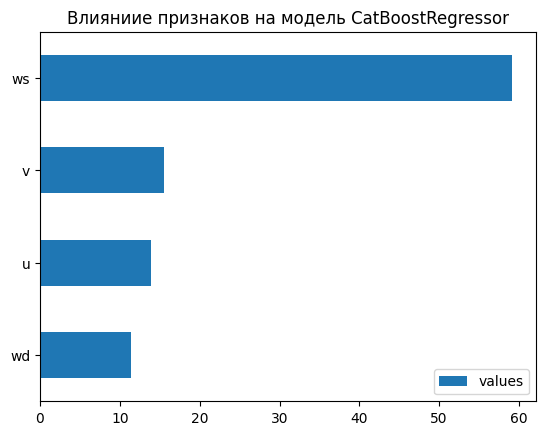

In [19]:
# Визуализцаия влияния признаков
cat_feature_importance_plot(train_df)

Создадим список для отбора категориальных признаков:

In [20]:
categorical = []

# 6. Разведочный анализ данных

На данном этапе, мы будем по очередно иссдовать каждый признак исходного датсета, выделять из него новые и добавлять в таблицу Х.

### time_stamp

**time_stamp - временная отметка каждого наблюдения в формате date_time, записанный в ввиде Д-М-Г. Ч:М:С**

Ветер возникает в результате неравномерного распределения атмосферного давления, он направлен от зоны высокого давления к зоне низкого давления. Вследствие непрерывного изменения давления во времени скорость и направление ветра также постоянно меняются. Т.к. скорость 

Выделим признак month, который будет отражать месяц в каждом наюлюдении:

In [21]:
train_df['month'] = train_df['date'].dt.month
categorical.append('month')

In [22]:
def plot_time_analysis(df: pd.DataFrame,
                       xlim: List,
                       ylabel: str,
                       title: str) -> None:
    """
    Создает plot() с необходимыми параметрами
    
    params:
    xlim (List): размер графика;
    title (str) : имя графика
    return None
    """
    df.plot()
    plt.grid()
    plt.xlim(xlim)
    plt.ylabel(ylabel)
    plt.title(title)

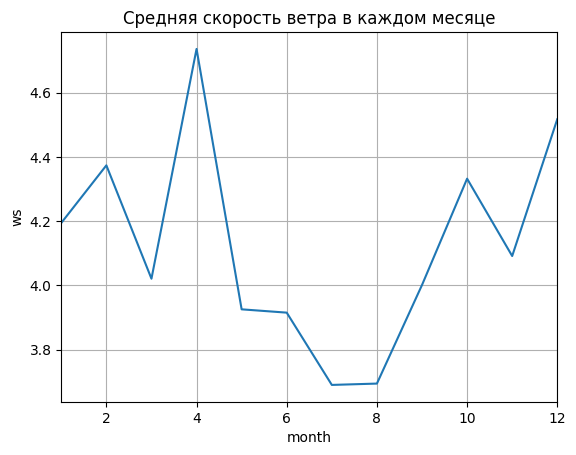

In [23]:
plot_time_analysis(train_df.groupby('month')['ws'].mean(),
                   [1,12],
                   'ws',
                   'Средняя скорость ветра в каждом месяце')

На данном графике зависимость скорости ветра от месяца. Из чего видно, что скорость линейно возрастает от летних месяцев и достигает пика в весенние месяцы. Предполагаю что категориальные признаки с временными отметками, отражающие время года, будут примерно храктеризовать скорость ветра, соответсвенно и мощность ветрогенератора.

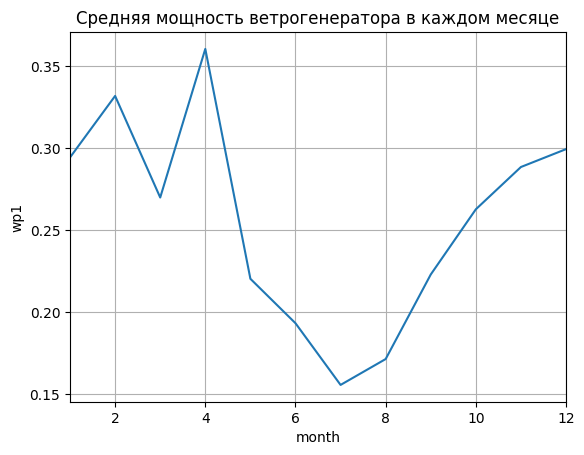

In [24]:
plot_time_analysis(train_df.groupby('month')['wp1'].mean(),
                   [1,12],
                   'wp1',
                   'Средняя мощность ветрогенератора в каждом месяце')

Зависимость мощности от месяца  очень идентична зависимость скорости от месяца, что делает мое предыдущее предположение верным.

Выделим признак quarter, характеризующий время года:

In [25]:
train_df['quarter'] = train_df['date'].dt.quarter
categorical.append('quarter')

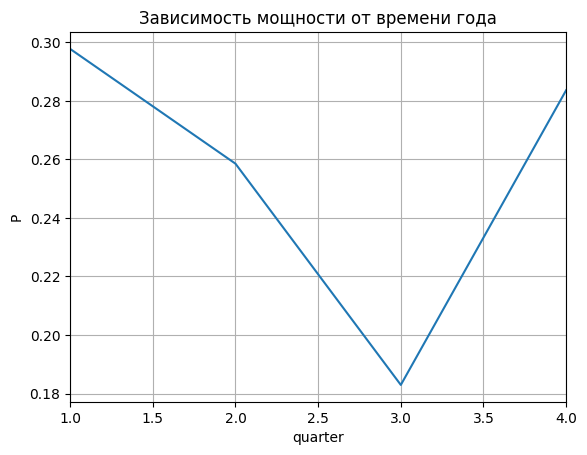

In [26]:
plot_time_analysis(train_df.groupby('quarter')['wp1'].mean(),
                   [1,4],
                   'P',
                   'Зависимость мощности от времени года')

Данная зависимость уже описана признаком month выше.

Выделим признак hour,как час наблюдения:

In [27]:
train_df['hour'] = train_df['date'].dt.hour
categorical.append('hour')

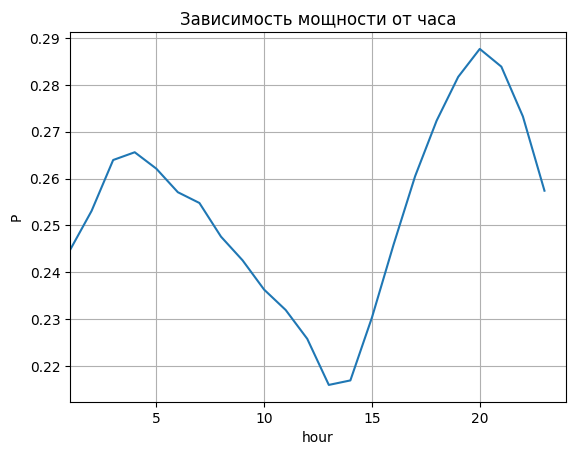

In [28]:
plot_time_analysis(train_df.groupby('hour')['wp1'].mean(),
                   [1,24],
                   'P',
                   'Зависимость мощности от часа')

Из зависимости видно, что в среднем мощность ветрогенратора минимальна днем в 13ч и линейно возрастает до 20ч, достигая своего пика. В остальное время мощность постепенно падает до свеого минимума.

In [29]:
cat_boost.score(train_df, cat_features=categorical)

'New MAE = 0.1148013923377176, old MAE = 0.12947223952547873, std =0.023942213431306494'

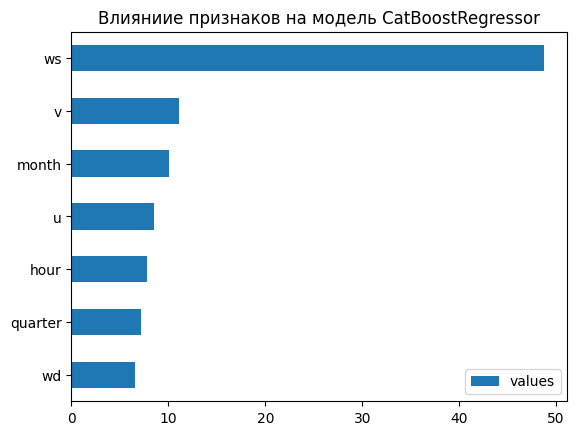

In [30]:
cat_feature_importance_plot(train_df, categorical)

### ws

*** ws - скорость ветра ***

На основе формул , объясняющих физическую природу признаков из пункта 1, корреляции, зависмостей установленных во время предыдущих исследований можно предположить, что скорость ветра - самый знаичимый признак в датасете и больше всего отражает мощность ветрогенератора (wp1). Посмотрим на эту взаимосвязь на графике:

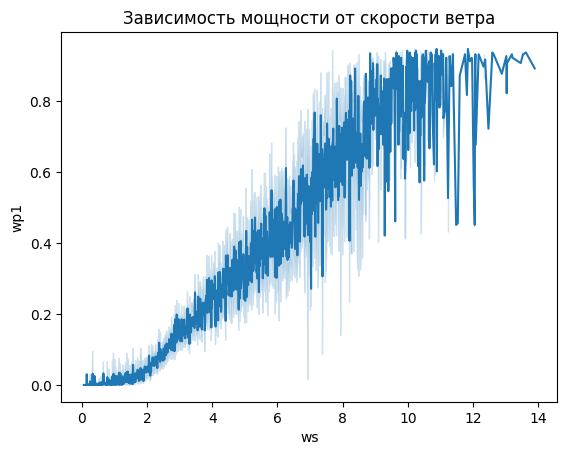

In [31]:
sns.lineplot(data=train_df, x='ws', y='wp1')
plt.title('Зависимость мощности от скорости ветра');

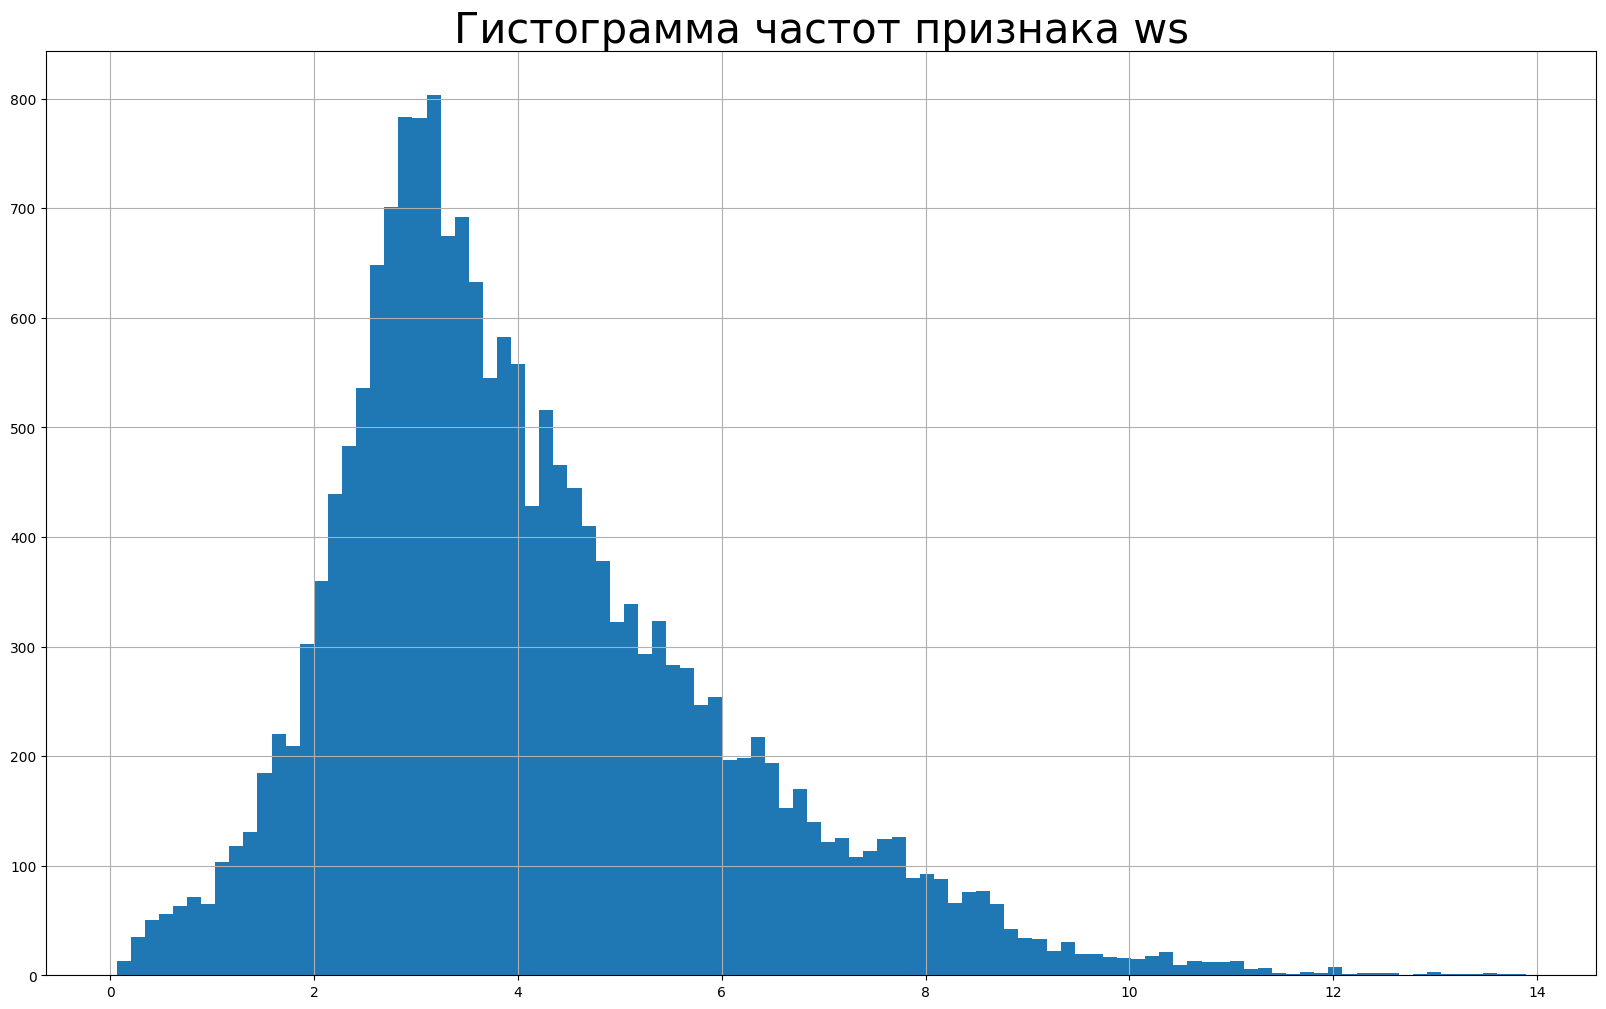

In [32]:
train_df.ws.hist(figsize=(20,12), bins=100)
plt.title('Гистограмма частот признака ws', fontsize=30);

Анализирую гистограмму признака ws , можно сделать увидеть значительное количество выбросов в области максимального значения.  Поскольку нашей выборке придется делится для теста, не будем ничего удалять. Для преобразования к нормальньному t-распределнию прологарифмируем признак и добавим 1 для того, чтобы значения меньше 0 не стремились к минус бесконечности. Предварительно проведем тест Колмагорова-Смирнова:

In [33]:
kstest(train_df.ws, 'norm')

KstestResult(statistic=0.8986826396854326, pvalue=0.0)

Значение pvalue = 0 , что означает отстутвсие нормального распредления внутри признака ws.

Посмотрим , что нам даст логарифмирование:

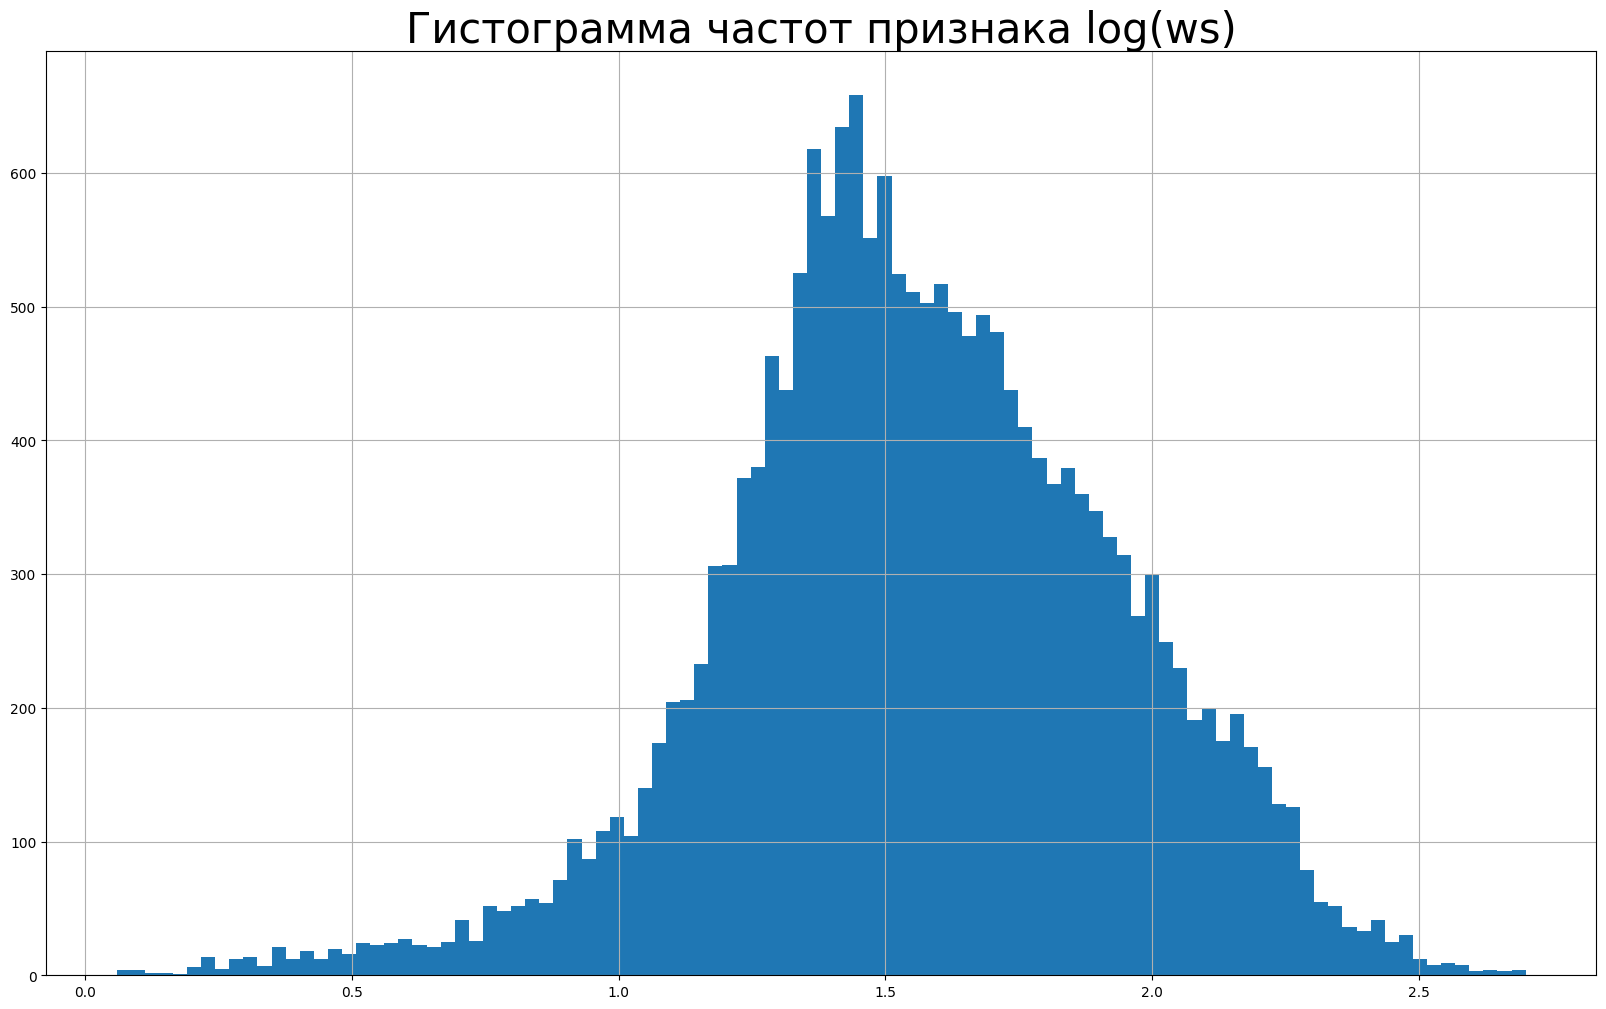

In [34]:
np.log(train_df.ws + 1) .hist(figsize=(20,12), bins=100)
plt.title('Гистограмма частот признака log(ws)', fontsize=30);

In [35]:
kstest(np.log(train_df.ws + 1), 'norm')

KstestResult(statistic=0.7830760215640092, pvalue=0.0)

Логарифмирование немного приблизило распредение к нормальному и убрало явные выбросы. Добавим данный признак и посмотрим , его влияние:

In [36]:
train_df['log_ws'] = np.log(train_df.ws + 1)
cat_boost.score(train_df, cat_features=categorical)

'New MAE = 0.11450384987650106, old MAE = 0.1148013923377176, std =0.024043523335852475'

Данный признак положительно влияет на модель, оставим его для дальнейших исследований.

### wd

*** wd - угол направления направление ветра***
$$ wd = \alpha - 90° $$

Для того, чтобы модель могла представлять данный признак в качестве компаса, а не просто числового рядо от 1-360, создами категориальную переменную direction , которая будет отображать 1 из 8 направлений , как предсатвленно на компасе ниже. Каждому направлению будет выделено 45° с центром посередине.

![Роза ветров](https://thumbs.dreamstime.com/b/%D1%88%D0%BA%D0%B0%D0%BB%D0%B0-%D0%BA%D0%BE%D0%BC%D0%BF%D0%B0%D1%81%D0%B0-10238186.jpg)

In [37]:
train_df['wd_direction'] = train_df.wd.apply(lambda x: 1 if x >= 338 and x < 360 else
                                         (2 if x >= 23 and x < 68 else
                                         (3 if x >= 68 and  x < 113 else
                                         (4 if x >= 113 and x < 158 else
                                         (5 if x >= 158 and x < 203 else
                                         (6 if x >= 203 and x < 248 else
                                         (7 if x >= 248 and x < 293 else 
                                         (8 if x >= 293 and x < 338 else 1))))))))

In [38]:
categorical.append('wd_direction')

In [39]:
train_df.wd_direction.nunique()

8

In [40]:
cat_boost.score(train_df,cat_features=categorical)

'New MAE = 0.11438272049753428, old MAE = 0.11450384987650106, std =0.023943201704832325'

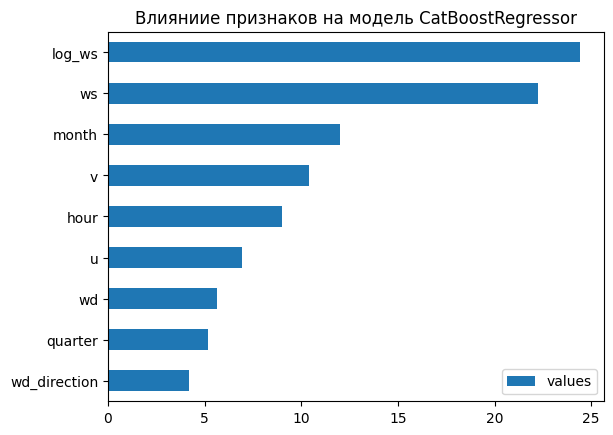

In [41]:
cat_feature_importance_plot(train_df, categorical);

Данный признак оказласся ссамым слабым для модели и только ухудшил финальный результат. Оставим ее для дальнейших исследований.

Создадим таблицу показывающую среднюю мощность по разным направлениям:

In [42]:
train_df.groupby(['wd_direction'])['wp1'].mean().sort_values(ascending=False)


wd_direction
2    0.325495
3    0.305300
1    0.247066
4    0.245732
7    0.233341
8    0.211155
5    0.157295
6    0.154258
Name: wp1, dtype: float64

Как оказалось движение ветра на восток и северо-восток, в среднем, дает прибаку в мощности в два раза больше чем на юг и юго-запад.

Попробую выделить категориальный признак соовтествующий низкой/средней/высокой мощности отталкиваясь от направления ветра:

In [43]:
train_df['power_of_direction'] = train_df.wd_direction.apply(lambda x: 1 if x in [5, 6] else
                                               (3 if x in [2,3] else 2))
categorical.append('power_of_direction')

Также выдллим бинарный признак с максимальным по мощности направлением:

In [44]:
train_df['wp_is_max'] = train_df.wd_direction.apply(lambda x: 1 if x in [2,3] else 0)
categorical.append('wp_is_max')

In [45]:
cat_boost.score(train_df, cat_features=categorical)

'MAE = 0.11478183912333276, Baseline = 0.11438272049753428, std = 0.024095835132238987'

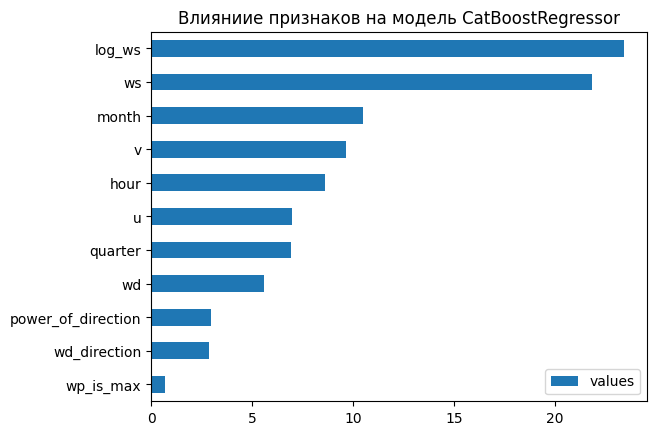

In [46]:
cat_feature_importance_plot(train_df, categorical);

Данные преоброзования не принесли пользы для данной модели, оставим признаки для пробы на других моделях.

Для ипользования wd в нахождении u/v , нужно wd нужно преобразовать его в alpha, используя формулу выше, и вычилить cos(alpha)/sin(alpha). Выделим эти значения в качетсве признаков и посмтрим как они повлияют на качетсво модели:


In [47]:
train_df['alpha'] = train_df.wd.apply(lambda x: x - 90 if x > 90.0 else 360 + x - 90 )
train_df['cos_aplha'] = np.cos(train_df.alpha)
train_df['sin_aplha'] = np.sin(train_df.alpha)

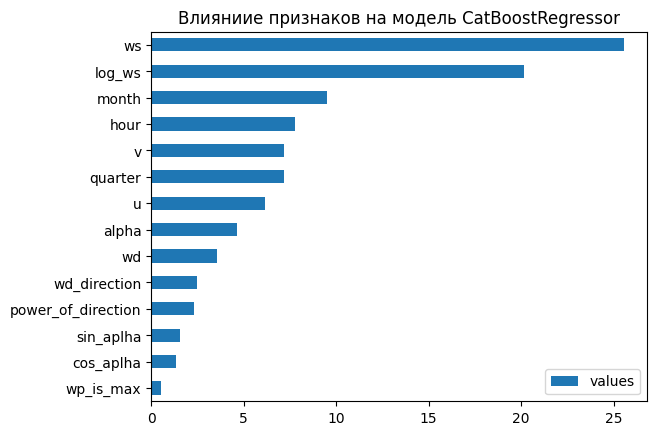

In [48]:
cat_feature_importance_plot(train_df, categorical);

Как видно cos/sin оказались бесполезны, но alpha оказывает большее влияние чем wd.

### u / v

 ***u - зональная составляющая вектора ветра***
$$ u = cos(\alpha)*ws $$
***v - меридиональная составляющая вектора ветра***  
$$v = sin(\alpha)*ws $$

Сначала ислледуем u, а после аналогичные действия проделаем с v.

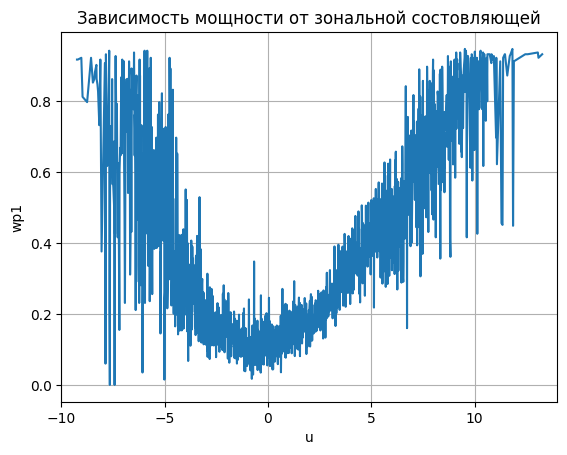

In [49]:
plot_time_analysis(train_df.groupby('u')['wp1'].mean(),
                   [-10,14],
                   'wp1',
                   'Зависимость мощности от зональной состовляющей')

Зависимость представлена ввиде параболы с минимумом в нуле , а это значит , что всякое изменение u больше или меньше 0 , будет увеличивать wp. Попробуем взять модуль от u , и тем самым сделать признак более линейным:

In [50]:
train_df['abs_u'] = train_df.u.apply(abs)

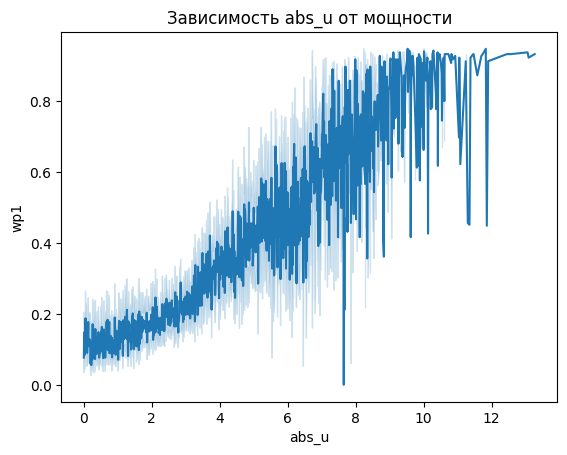

In [51]:
sns.lineplot(data=train_df, x='abs_u', y='wp1')
plt.title('Зависимость abs_u от мощности');

In [52]:
cat_boost.score(train_df, cat_features=categorical)

'MAE = 0.11491619097038744, Baseline = 0.11438272049753428, std = 0.023889385394089295'

Модуль положительно повлиял на модель.  
Положительное значение u , соотносится с восточным напрпалением ветра, а отриацательное с западным. Сделаем бинарный признак , соответсвующий этим условиям:

In [53]:
train_df['gorizont'] = train_df.u.map(lambda x: 'e' if x >= 0 else 'w')

Проделаем аналогичные операции с v:

In [54]:
train_df['abs_v'] = train_df.v.apply(abs)

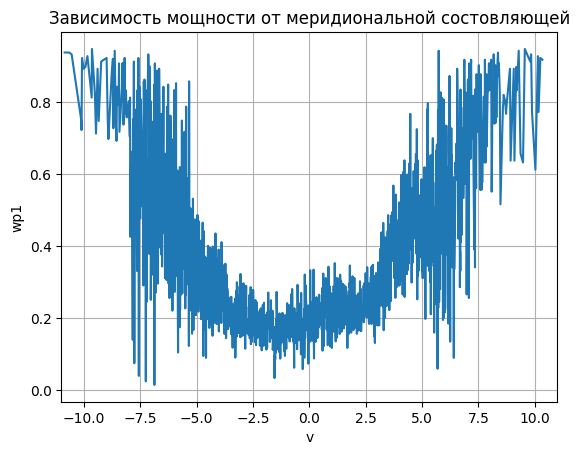

In [55]:
plot_time_analysis(train_df.groupby('v')['wp1'].mean(),
                   [-11,11],
                   'wp1',
                   'Зависимость мощности от меридиональной состовляющей')

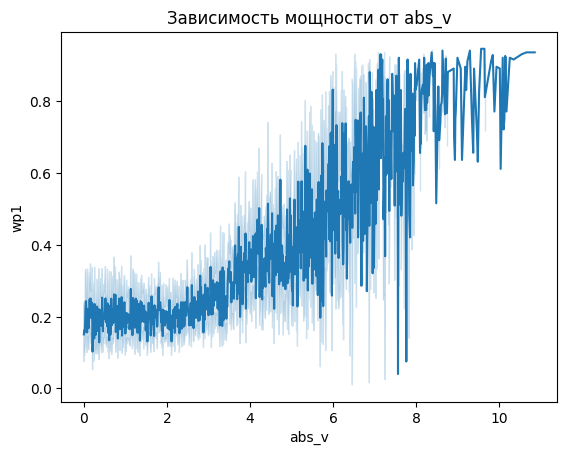

In [56]:
sns.lineplot(data=train_df, x='abs_v', y='wp1')
plt.title('Зависимость мощности от abs_v');

Выделим бинарный признак отражающий движение ветра на север:

In [57]:
train_df['vertik'] = train_df.v.map(lambda x: 'n' if x >= 0 else 's')

Совместим признак vertik и gorizont , чтобы отразить направление движение ветра , опираясь на u и v:

In [58]:
train_df['direction_u_v'] = (train_df.vertik + train_df.gorizont).apply(lambda x: 1 if x=='nw'
                                            else (2 if x=='ne'
                                                 else (3 if x=='se' else 4)))

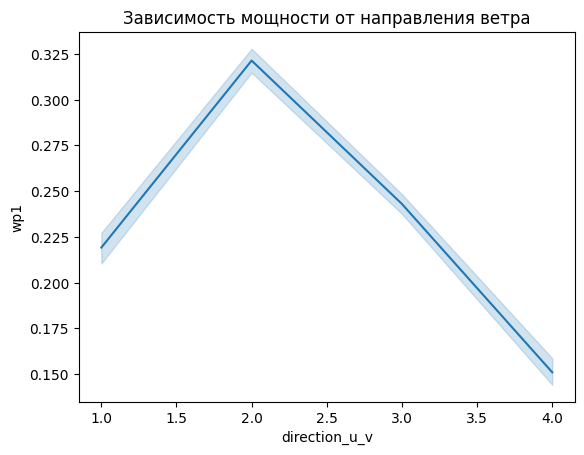

In [59]:
sns.lineplot(data=train_df, x='direction_u_v', y='wp1')
plt.title('Зависимость мощности от направления ветра');

Переведем признаки в численный формат для удобства:

In [60]:
train_df['gorizont'] = train_df.u.map(lambda x: 1 if x == 'e' else 0)
train_df['vertik'] = train_df.v.map(lambda x: 1 if x == 'n'  else 0)

In [61]:
categorical.append('gorizont')
categorical.append('vertik')
categorical.append('direction_u_v')

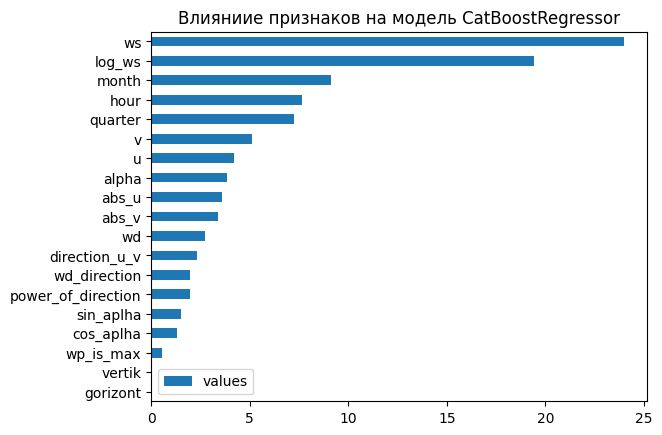

In [62]:
cat_feature_importance_plot(train_df, categorical);

### Wp1

- wp1 - (wind power)отнормированная мощность одного ветрогенератора
$$ wp = \frac{ws³*d²*ξ}{2080} $$

Поробуем выделить в признаки средние значения по некоторым категориальным признакам созданым выше. А именно:  
- month - mean(wp1)
- hour - mean(wp1)
- quarter - mean(wp1)
- wd_direction - mean(wp1)
- direction_u_v - mean(wp1)

In [63]:
cat_features_goupby = ["month", "hour", "quarter", "wd_direction", "direction_u_v"]

Так как предпологается, что целевая переменная в test неизвестна, поэтому будем брать среднее из train части:

In [64]:
train_df_new = train_df.iloc[:treshold, 1:]
test_df = train_df.iloc[:treshold, 1:]

In [65]:
def groupby_feature_df(X: pd.DataFrame,
                       X_merge: pd.DataFrame,
                       cat_feature: str,
                       feature: str
                       ) -> pd.DataFrame:
    """ 
    Создает pd.DataFrame из train_df с новой сгруппированной фичей.
    Params:
    X (pd.DataFrame): датафрейм
    cat_feature (str): фича по кооторой группируем
    feature (str): фича по которой берем среднее
    return pd.DataFrame
    """
    groupby_feature = X.groupby(cat_feature)[feature].mean().rename(f'mean_{cat_feature}_{feature}')

    return X_merge.merge(groupby_feature,on=cat_feature , how='inner')

In [66]:
for cat_feature in cat_features_goupby:
    train_df = groupby_feature_df(train_df_new, train_df, cat_feature, 'wp1')

Создаим аналогичные признаки с ws.  
Для train_df_new и test_df mean(ws) бдует разным, поэтому для каждой выборки найдем свои mean(ws) и соеденим 2 таблицы в одну:

In [67]:
test_df = train_df[treshold:]
train_df_new = train_df[:treshold]

In [68]:
# Для train
for cat_feature in cat_features_goupby:
    train_df_new = groupby_feature_df(train_df_new, train_df_new, cat_feature, 'ws')

In [69]:
# Для test
for cat_feature in cat_features_goupby:
    test_df = groupby_feature_df(test_df, test_df, cat_feature, 'ws')

Соеденим таблицы:

In [70]:
train_df = pd.concat([train_df_new, test_df], ignore_index=True)

На данном этапе мы не будем оценивать влияние новых признаков, а вернемся к этому этапу при тестировании разных моделей.

### Перемножение признаков

На основе имеющихся у нас признаков создадим полином 2 степени.

In [71]:
poly = PolynomialFeatures(degree=2)

In [72]:
polinom_data = pd.DataFrame(poly.fit_transform(train_df.iloc[:,2:]),
                            columns =poly.get_feature_names_out()).iloc[:,1:] 
# сделаем срез, чтобы убрать еденичную колонку

In [73]:
polinom_data.shape

(18756, 464)

Переведем категорильные признаки из float в int:

In [74]:
for column in categorical:
    polinom_data[column] = polinom_data[column].apply(int)

# 7. Выбор модели

Разделим датасет на train / test:

In [79]:
# полином из 464 признаков
X_train_polinom = polinom_data[:treshold]
X_test_polinom= polinom_data[treshold:]

# целевая переменная
y_train = train_df.wp1[:treshold]
y_test = train_df.wp1[treshold:]

# Датасет из 29 признаков, до создания полинома
X_train = train_df.iloc[:,2:][:treshold]
X_test = train_df.iloc[:,2:][treshold:]

## 1) LinearRegression

### Выбор признаков

Попробуем отобрать лучшее количество признаков , дающее минимальный МАЕ на кроссвалидации: 

#### 1 варинт : добаляем и тестируем  
Попробуем добавлять по одному призанку и сравнивать МАЕ на кроссвалидации с знчаением до добавления признака и после:

In [207]:
lin_reg = Model_score('lin')

МАЕ до отбора признаков:

In [76]:
first_try = lin_reg.score(X_train_polinom, is_print=False, y=y_train)
print("MAE = {}, std = {}".format(first_try[0], first_try[1]))

MAE = 1272366.5877487352, std = 3817094.354607364


In [208]:
values_series = pd.Series()
basic_df = X_train_polinom.iloc[:,:1]
positive_features = []

for feature in X_train_polinom.columns[1:]:
    first_test = lin_reg.score(basic_df, is_print=False, y=y_train)[1]
    basic_df[feature] = X_train_polinom[feature]
    
    second_test = lin_reg.score(basic_df, is_print=False, y=y_train)[1]
    if second_test - first_test <= 0:
        positive_features += [feature]
        values_series[feature] = lin_reg.score(basic_df, is_print=False, y=y_train)[1]
    else:
        basic_df = basic_df.drop(feature, axis=1)

In [78]:
first_var = lin_reg.score(X_train_polinom[positive_features], is_print=False, y=y_train)
print('MAE = {}, MAE + std = {}, Отобрано {} признака'.format(first_var[0], first_var[1], len(positive_features)))

MAE = 0.12317897453683901, MAE + std = 0.13169147663098776, Отобрано 93 признака


#### 2 вариант : K-best

Используем функцию отбора призанков K-Best из пакета sklearn:  
Попробуем разное количество лучших признаков.

In [79]:
min_MAE = 1
for iteration in range(1,200):
    df = pd.DataFrame(SelectKBest(f_regression, k=iteration).fit_transform(X_train_polinom, y_train))
    predict = lin_reg.score(df, is_print=False, y=y_train)
    if predict[1] < min_MAE:
            min_MAE = predict[1]
            best_iteration_kbest = {'k_best':iteration, 'Best_MAE':predict[0], "Best_MAE_std":predict[1]}

MAE после отбора признаков:

In [80]:
print('MAE = {}, MAE + std = {}, Отобрано {} признака'.format(best_iteration_kbest['Best_MAE'], 
                                                              best_iteration_kbest['Best_MAE_std'],
                                                              best_iteration_kbest['k_best']))

MAE = 0.12047887887107574, MAE + std = 0.13717673396670538, Отобрано 25 признака


#### 3 вариант :  Random forest feature importance

В этом варианте будем ипользовать написанный выше класс **Model_score** для отбора признаков:

In [81]:
lin_reg = Model_score('lin')
lin_reg.feature_importance(X_train_polinom, y_train)
lin_reg_feature_importance = lin_reg.feature_importance_best_treshold(X_train_polinom,
                                                                      np.arange(0.001, 0.01, 0.0001),
                                                                      y=y_train)
lin_reg_feature_importance

{'treshold': 0.0024999999999999996, 'Best_MAE_std': 0.13630959415966576}

In [83]:
print('MAE + std = {}, граница разделения признаков = {}'.format(lin_reg_feature_importance['Best_MAE_std'], 
                                                              lin_reg_feature_importance['treshold']))

MAE + std = 0.13630959415966576, граница разделения признаков = 0.0024999999999999996


#### Выберем луший способ

Отбирать будем по самомой минимальной сумме МАЕ + std:

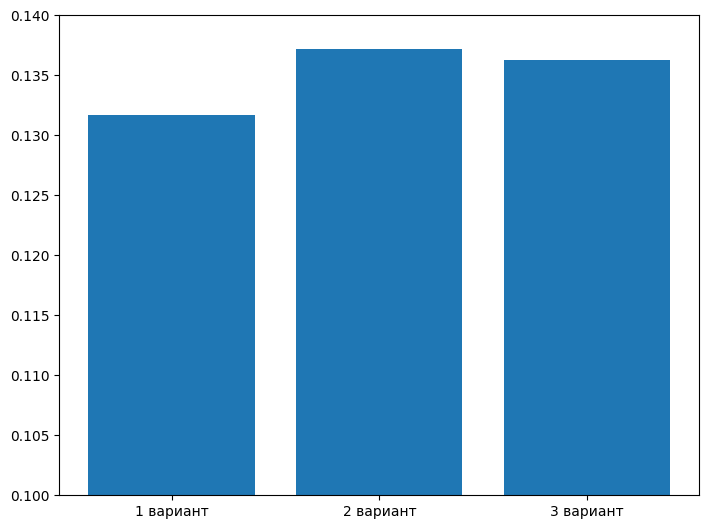

In [84]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
varience = ['1 вариант', '2 вариант', '3 вариант']
values = [first_var[1], best_iteration_kbest['Best_MAE_std'], lin_reg_feature_importance['Best_MAE_std']]
plt.ylim(0.1,0.14)
ax.bar(varience,values)
plt.show()

1 вариант MAE = 0.1231, MAE + std = 0.1316, оказался самым результативный. Выделим новые df с лучшими фичами:

In [209]:
lin_reg_X_train = X_train_polinom[positive_features]
lin_reg_X_test = X_test_polinom[positive_features]

### Регуляризация Linnear regression

Будем проводить **регуляризацию** , 3 моделями из пакета sklearn: Lasso, Ridge и ElasticNet, соответвутсвующие L1, L2 и комбинированной регуляризации. После регуляризации сразу проверим на тестовых данных и сравним результаты.

Для достижения лучшего качества отлагорифмируем целевую переменную перед обучением и проэкспонируем после предсказания:

In [85]:
def log_func(x:float) -> float:
    return np.log(x + 1) 

def exp_func(x:float) -> float:
    return np.exp(x) - 1

In [211]:
def regularization_linnear_model( X_train: pd.DataFrame,
                                  X_test: pd.DataFrame
                                 ) -> dict:
    linn_model = {}
    for model, param in zip([Lasso(), Ridge(), ElasticNet()],
                        [param_lasso, param_ridge, param_elastic]):
        
        grid_search = GridSearchCV(estimator=model,
                              param_grid=param,
                              cv=10,
                              scoring='neg_mean_absolute_error',
                              n_jobs=None)
        grid_search.fit(X_train, y_train)
        
        target_regressor = TransformedTargetRegressor(regressor=grid_search.best_estimator_,
                                                  func=log_func,
                                                 inverse_func=exp_func)
        target_regressor.fit(X_train, y_train)
        
        test_MAE = mean_absolute_error(target_regressor.predict(X_test), y_test)

        linn_model[str(model)[:-2]] = {'train_score': grid_search.best_score_ * -1,
                                             'std': grid_search.cv_results_['std_test_score'].mean(),
                                             'best_params': grid_search.best_params_,
                                             'test_MAE': test_MAE}
    return linn_model
    

Параметры регуляризации для GridSearchCV:

In [212]:
param_lasso = {'alpha': np.linspace(0.01, 10, 100),
               'random_state' : [SEED]}

param_ridge = {'alpha': np.logspace(-2, 6,500),
               'random_state' : [SEED]}

param_elastic = {'alpha' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
                 'l1_ratio' : np.arange(0, 1, 0.01),
                 'random_state' : [SEED]}

Датасеты для регуляризации:

In [213]:
datasets_for_regulariazation = zip([X_train, X_train_polinom, lin_reg_X_train],
                                   [X_test, X_test_polinom, lin_reg_X_test],
                                   ['X_train', 'X_train_polinom', 'lin_reg_X_train'])

In [214]:
best_lin_model = {}
for train, test, name in datasets_for_regulariazation:
    best_lin_model[name] = regularization_linnear_model(train, test)

Словарик с результатами:

In [269]:
best_lin_model

{'X_train': {'Lasso': {'train_score': 0.13131565206429183,
   'std': 0.018701193475930564,
   'best_params': {'alpha': 0.01, 'random_state': 1},
   'test_MAE': 0.11920567824935643},
  'Ridge': {'train_score': 0.12401028138994925,
   'std': 0.01971517443413565,
   'best_params': {'alpha': 0.38652211626312616, 'random_state': 1},
   'test_MAE': 0.11453981516506198},
  'ElasticNet': {'train_score': 0.12378918712937956,
   'std': 0.019154000583149117,
   'best_params': {'alpha': 0.0, 'l1_ratio': 0.0, 'random_state': 1},
   'test_MAE': 0.19049012716048566}},
 'X_train_polinom': {'Lasso': {'train_score': 0.12541930097501414,
   'std': 0.016626054067109524,
   'best_params': {'alpha': 0.01, 'random_state': 1},
   'test_MAE': 0.3548060600338369},
  'Ridge': {'train_score': 0.12489390837871199,
   'std': 0.20286705496589483,
   'best_params': {'alpha': 163843.36455779814, 'random_state': 1},
   'test_MAE': 0.34658412272904815},
  'ElasticNet': {'train_score': 0.12227102830634273,
   'std': 0.01

Визуализируем результат:

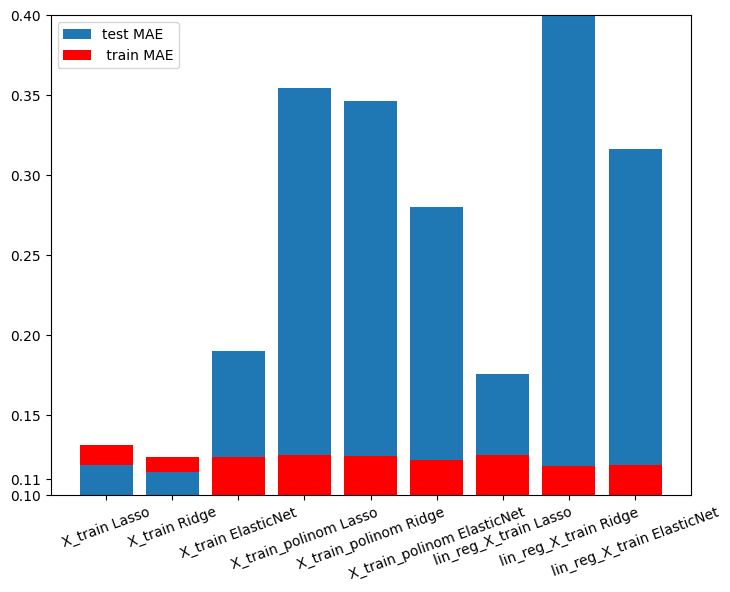

In [453]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
values = []
name_columns = []
train_values = []
for dataset_name, dataset_values in best_lin_model.items():
    for model, model_values in dataset_values.items():
        values.append(model_values['test_MAE'])
        train_values.append(model_values['train_score'])
        name_columns.append(dataset_name +' '+ model)

ax.bar(name_columns,values)
ax.bar(name_columns,train_values, color = 'red')
ax.bar(name_columns[:2],values[:2], color = 'tab:blue')

plt.ylim(0.1,0.4)
plt.xticks(range(9), rotation=20)
y_ticks = list(np.arange(0.1, 0.4, 0.05))
y_ticks.append(round(min(values),2))
plt.yticks(y_ticks)
plt.legend(['test MAE', ' train MAE'])

plt.show()

Лучший результат получился на датасете **X_train**, **Ridge** модели с параметром alpha = 0.3865  , **MAE =  0.1145**

## 2) RandomForest

### Выбор признаков

Запустим цикл, в котором будем перебирать границу разделения признаков (**feature_importance_treshold**).Каждую итерацию занесем таблицу, для наглядного воспроизведения эксперемента и границу дающий минимальный МАЕ сохраним отдельно в словарь. 

In [153]:
forest = Model_score('forest')
forest.feature_importance(X_train_polinom, y_train)
forest_feature_importance = forest.feature_importance_best_treshold(df=X_train_polinom, 
                                                                    frange=np.arange(0, 0.0040, 0.0002),
                                                                     y=y_train)
forest_feature_importance

{'treshold': 0.0028, 'Best_MAE_std': 0.1328764503912265}

Граница равная = 0.0028, дает лучший МАЕ в данном варианте отбора признаков(MAE + std = 0.1328).  
Визуализируем поиск лучшего значения:

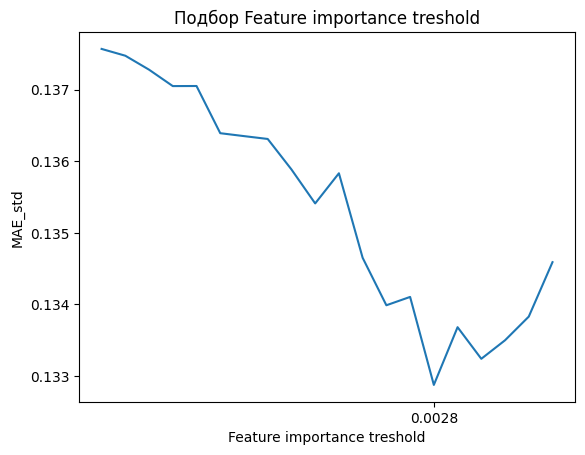

In [154]:
forest.feature_importance_values_plot()

Дата фрейм с лучшим набором признаков для RandomForest:

In [157]:
forest_best_X_train_polinom = X_train_polinom[forest.df_feature_importance[forest.df_feature_importance.value > forest_feature_importance['treshold']].index]
forest_best_X_test_polinom = X_test_polinom[forest.df_feature_importance[forest.df_feature_importance.value > forest_feature_importance['treshold']].index]

In [342]:
print(f'Отобрано {forest_best_X_train_polinom.shape[1]} признака')

Отобрано 42 признака


Повторим те же действия для ***X_train, X_test***: 

In [158]:
forest.feature_importance(X_train, y_train)
forest_feature_importance = forest.feature_importance_best_treshold(df=X_train, 
                                                                    frange=np.arange(0, 0.0040, 0.0002),
                                                                     y=y_train)
forest_best_X_train = X_train[forest.df_feature_importance[forest.df_feature_importance.value > forest_feature_importance['treshold']].index]
forest_best_X_test = X_test[forest.df_feature_importance[forest.df_feature_importance.value > forest_feature_importance['treshold']].index]

In [345]:
print(f'Отобрано {forest_best_X_train.shape[1]} признаков')

Отобрано 20 признаков


### Настройка гиперпараметров

Для нахождения оптимальных гиперпараметров используем RandomizedSearchCV с 500 итерациями на каждый датасет. После нахождения лучших результатов на 5-fold кроссвалидаци проверим лучшую модель на тестовыхд данных. Перед финальным тестированием отлогарфмируем целевую переменную и проэкспонируем обтрано для отображения МАЕ:

In [164]:
def search_best_forest_params( X_train: pd.DataFrame,
                        X_test: pd.DataFrame) -> dict:
    
    dict_with_results = {}
    grid_search = RandomizedSearchCV(estimator=RandomForestRegressor(),
                          param_distributions=param_forest,
                          cv=5,
                          n_iter=500,
                          n_jobs=-1,
                          scoring='neg_mean_absolute_error')
    grid_search.fit(X_train, y_train)
    target_regressor = TransformedTargetRegressor(regressor=grid_search.best_estimator_,
                                              func=log_func,
                                             inverse_func=exp_func)
    target_regressor.fit(X_train, y_train)
    test_MAE = mean_absolute_error(target_regressor.predict(X_test), y_test)
    dict_with_results[str(RandomForestRegressor())[:-2]] = {'train_score': grid_search.best_score_ * -1,
                                         'std': grid_search.cv_results_['std_test_score'].mean(),
                                         'best_params': grid_search.best_params_,
                                         'test_MAE': test_MAE}
    return dict_with_results
    

Сетка гиперпараметров:

In [165]:
param_forest = {
    'n_estimators': range(100,500,50),
    'max_depth': [ 5, 9, 11, 15,  20,  24, 30, 34, 38],
    'min_samples_leaf': [1 ,3, 7, 9, 13, 15, 22, 24, 30],
    'max_features': [2, 4, 6, 8, 10, 12, 14, 16]}

Датасеты учавствующие в тестах:

In [166]:
datasets_for_randomforest = zip([X_train, forest_best_X_train, X_train_polinom, forest_best_X_train_polinom],
                                [X_test, forest_best_X_test, X_test_polinom, forest_best_X_test_polinom],
                                ['X_train', 'forest_best_X_train', 'X_train_polinom', 'forest_best_X_train_polinom'])

In [167]:
best_randomforest_model = {}
for train, test, name in datasets_for_randomforest:
    best_randomforest_model[name] = search_best_forest_params(X_train=train, 
                                                       X_test=test)

Словарь с результатами:

In [270]:
best_randomforest_model

{'X_train': {'RandomForestRegressor': {'train_score': 0.11642753792738114,
   'std': 0.01655206650511177,
   'best_params': {'n_estimators': 300,
    'min_samples_leaf': 7,
    'max_features': 16,
    'max_depth': 20},
   'test_MAE': 0.1028463138324793}},
 'forest_best_X_train': {'RandomForestRegressor': {'train_score': 0.1160868053250784,
   'std': 0.016140327437837238,
   'best_params': {'n_estimators': 250,
    'min_samples_leaf': 7,
    'max_features': 14,
    'max_depth': 30},
   'test_MAE': 0.10321686746966136}},
 'X_train_polinom': {'RandomForestRegressor': {'train_score': 0.11865902432734828,
   'std': 0.01675620149139349,
   'best_params': {'n_estimators': 400,
    'min_samples_leaf': 13,
    'max_features': 16,
    'max_depth': 30},
   'test_MAE': 0.10530905278876103}},
 'forest_best_X_train_polinom': {'RandomForestRegressor': {'train_score': 0.1147782276548189,
   'std': 0.015127325999774571,
   'best_params': {'n_estimators': 250,
    'min_samples_leaf': 7,
    'max_feature

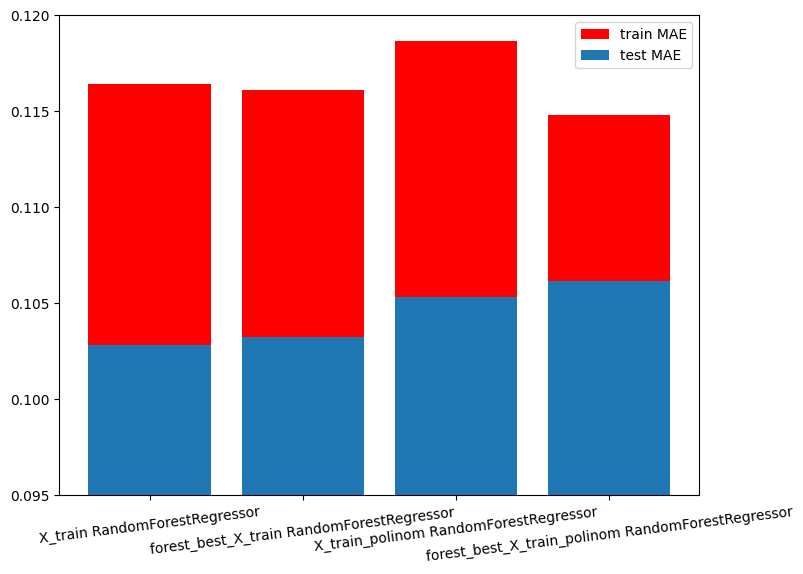

In [317]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
values = []
name_columns = []
train_values = []
for dataset_name, dataset_values in best_randomforest_model.items():
    for model, model_values in dataset_values.items():
        values.append(model_values['test_MAE'])
        train_values.append(model_values['train_score'])
        name_columns.append(dataset_name +' '+ model)

ax.bar(name_columns,train_values, color = 'red')
ax.bar(name_columns,values)

plt.ylim(0.095,0.12)
plt.xticks(range(4), rotation=7)
y_ticks = list(np.arange(0.1, 0.4, 0.05))
y_ticks.append(round(min(values),2))
plt.legend(['train MAE', 'test MAE'])

plt.show()

Лучший результат получился на датасете **X_train**, с параметрами {'train_score': 0.11642753792738114,
   'std': 0.01655206650511177,
   'best_params': {'n_estimators': 300,
    'min_samples_leaf': 7,
    'max_features': 16,
    'max_depth': 20},  **MAE = 0.1028**

## 3) Cat Boost

#### Отбор признаков

Будем отбирать признаки с помощью feature_importance из бибилиотеки Catboost:

In [169]:
cat = Model_score('cat')
cat.feature_importance(X_train_polinom, y_train, cat_features=categorical)

Узнаем границу feature_importance, ниже которой мы не будем брать признаки:

In [172]:
cat_feature_importance = cat.feature_importance_best_treshold(X_train_polinom,
                                                              np.arange(0,0.0013,0.0001),
                                                              y_train)

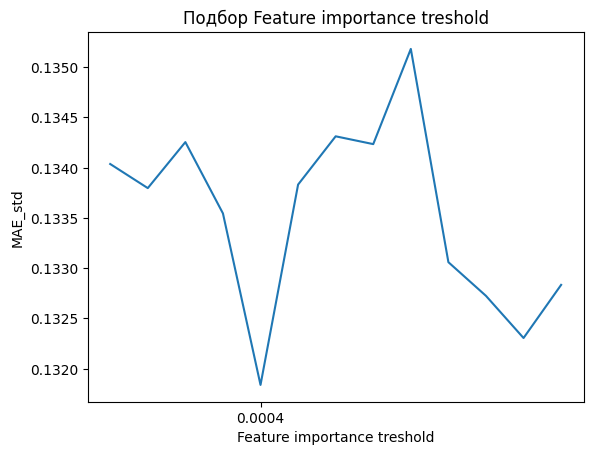

In [173]:
cat.feature_importance_values_plot()

Создадим новый датсет с лушими признаками для Catboost:

In [174]:
catboost_best_X_train_polinom = X_train_polinom[cat.df_feature_importance[cat.df_feature_importance.value>cat_feature_importance['treshold']].index]
catboost_best_X_test_polinom = X_test_polinom[cat.df_feature_importance[cat.df_feature_importance.value>cat_feature_importance['treshold']].index]

In [341]:
print(f'Отобран {catboost_best_X_train_polinom.shape[1]} признак')

Отобран 251 признак


Повторим те же действия для **X_train, X_test**:

In [175]:
cat.feature_importance(X_train, y_train, cat_features=categorical)
cat_feature_importance = cat.feature_importance_best_treshold(X_train,
                                                              np.arange(0,0.0013,0.0001),
                                                              y_train)
catboost_best_X_train = X_train[cat.df_feature_importance[cat.df_feature_importance.value>cat_feature_importance['treshold']].index]
catboost_best_X_test = X_test[cat.df_feature_importance[cat.df_feature_importance.value>cat_feature_importance['treshold']].index]

In [339]:
print(f'Отобрано {catboost_best_X_train.shape[1]} признака')

Отобрано 24 признака


#### Настройка гиперпараметров

Проведем поиск лучших параметров по сетке используя GridSearchCV на 3 датасетах. После нахождения лучших результатов на 5-fold кроссвалидаци проверим лучшую модель на тестовыхд данных. Перед финальным тестированием отлогарфмируем целевую переменную и проэкспонируем обтрано для отображения МАЕ:

In [244]:
def search_best_catboost_params( X_train: pd.DataFrame,
                        X_test: pd.DataFrame) -> dict:
    
    dict_with_results = {}
    model = CatBoostRegressor(verbose=False, random_state=SEED)
    grid_search = GridSearchCV(estimator=model,
                          param_grid=param_catbost,
                          cv=5,
                          scoring='neg_mean_absolute_error')
    grid_search.fit(X_train, y_train)
    target_regressor = TransformedTargetRegressor(regressor=grid_search.best_estimator_,
                                              func=log_func,
                                             inverse_func=exp_func)
    target_regressor.fit(X_train, y_train)
    test_MAE = mean_absolute_error(target_regressor.predict(X_test), y_test)
    dict_with_results['CatBoostRegressor'] = {'train_score': grid_search.best_score_ * -1,
                                         'std': grid_search.cv_results_['std_test_score'].mean(),
                                         'best_params': grid_search.best_params_,
                                         'test_MAE': test_MAE}
    return dict_with_results

Сетка гиперпараметров:

In [245]:
param_catboost = {
        'learning_rate': [0.01, 0.05],
        'depth': [6, 8, 10, 12, 14],
        'l2_leaf_reg': [1, 3, 5, 7],
        'one_hot_max_size': [10],
        'early_stopping_rounds':[100]}

Датасеты учавствующие в тестах:

In [246]:
datasets_for_catboost = zip([X_train, catboost_best_X_train, catboost_best_X_train_polinom],
                                [X_test, catboost_best_X_test, catboost_best_X_test_polinom],
                                ['X_train', 'catboost_best_X_train', 'catboost_best_X_train_polinom'])

In [247]:
best_catboost_model = {}
for train, test, name in datasets_for_catboost:
    best_catboost_model[name] = search_best_catboost_params(X_train=train, 
                                                          X_test=test)

Словарь с результатами:

In [266]:
best_catboost_model

{'X_train': {'CatBoostRegressor': {'train_score': 0.11478250930827075,
   'std': 0.016936818576861856,
   'best_params': {'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.01},
   'test_MAE': 0.1013489872101644}},
 'catboost_best_X_train': {'CatBoostRegressor': {'train_score': 0.11497653774781029,
   'std': 0.016838471359783207,
   'best_params': {'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.01},
   'test_MAE': 0.10146694311146483}},
 'catboost_best_X_train_polinom': {'CatBoostRegressor': {'train_score': 0.11568267370820404,
   'std': 0.016239357433092683,
   'best_params': {'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.01},
   'test_MAE': 0.10530258272518943}}}

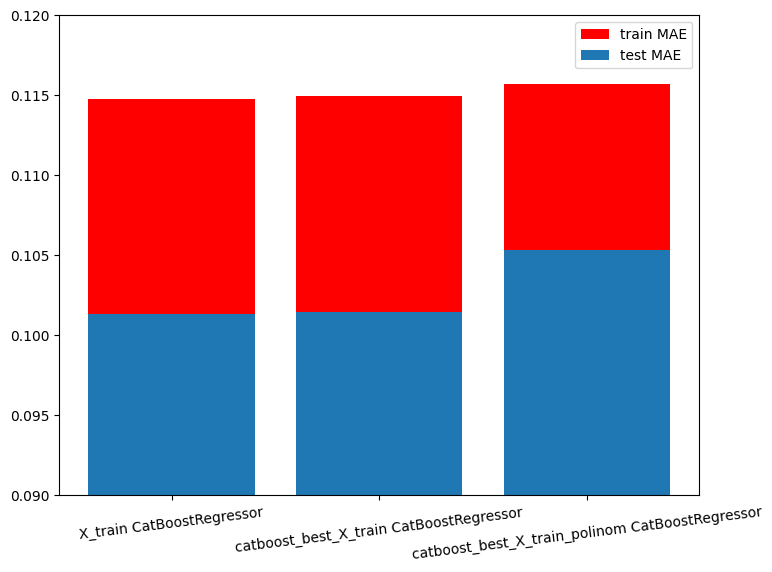

In [318]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
values = []
name_columns = []
train_values = []
for dataset_name, dataset_values in best_catboost_model.items():
    for model, model_values in dataset_values.items():
        values.append(model_values['test_MAE'])
        train_values.append(model_values['train_score'])
        name_columns.append(dataset_name +' '+ model)

ax.bar(name_columns,train_values, color = 'red')
ax.bar(name_columns,values)

plt.ylim(0.09,0.12)
plt.xticks(range(3), rotation=7)
y_ticks = list(np.arange(0.1, 0.4, 0.05))
y_ticks.append(round(min(values),2))
plt.legend(['train MAE', 'test MAE'])

plt.show()

Лучший результат получился на датасете **X_train**, с параметрами {'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.01}, **MAE =  0.1013**

## Выбор лучшей модели

Сравним минимальные значения МАЕ всех трех моделей:

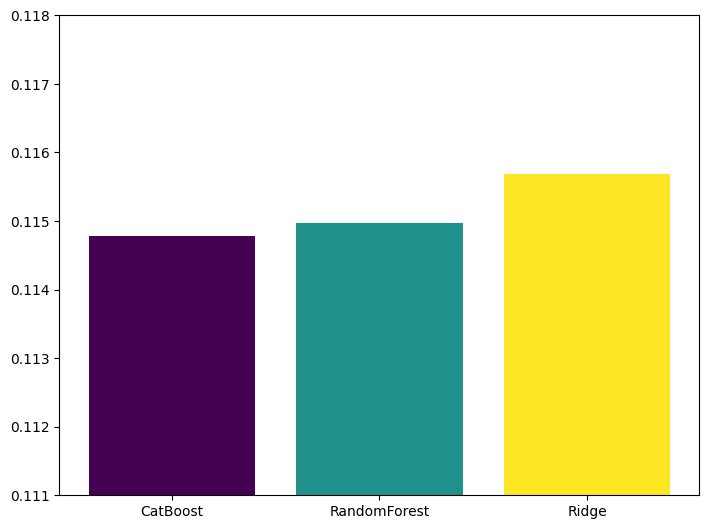

In [299]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
values = []
MAE_models_values = [best_lin_model['X_train']['Ridge']['test_MAE'],
                     best_randomforest_model['X_train']['RandomForestRegressor']['test_MAE'],
                     best_catboost_model['X_train']['CatBoostRegressor']['test_MAE']]
name_columns = ['CatBoost', 'RandomForest', 'Ridge']
cmap = plt.get_cmap('viridis')
ax.bar(name_columns,train_values, color=cmap(np.linspace(0, 1, len(name_columns))))
plt.ylim(0.111,0.118)
y_ticks = list(np.arange(0.1, 0.4, 0.05))
plt.show()

Catboost показала лучший результат, сохраним ее.

# 8. Сохранение модели 

In [314]:
save_catboost = CatBoostRegressor(depth = 6, 
                                  l2_leaf_reg = 1,
                                  learning_rate = 0.01,
                                  one_hot_max_size = 10,
                                  verbose=False, 
                                  random_state=SEED)
target_regressor = TransformedTargetRegressor(regressor=save_catboost,
                                              func=log_func,
                                             inverse_func=exp_func)
target_regressor.fit(X_train, y_train);

In [307]:
with open('catboost_model.pkl','wb') as f:
    pickle.dump(target_regressor,f)

In [353]:
y_train_log = y_train.apply(log_func)

In [354]:
save_catboost.fit(X_train, y_train_log)
with open('catboost_model.pkl','wb') as f:
    pickle.dump(save_catboost,f)

# 9. Итоги

В ходе проделанной работы мы:  
1) Провели первичную обработку данных, при которой обнаружили, что не нулевые значения отсутствуют и удаление аномальных значений данных не приносит значимых результатов;  
2) Дополнили начальный датасет 25 новыми признаками, получив при этом датасет из 29 признака, готовых для обработки под модели. А также сгенерировали полином второй степени, из 464 признаков, в надежде получить от них пользу при постороении модели;  
3) Отобрали в каждом датасете лучшие признаки и гиперпараметры. Оказалось, что датасет из 29 признаков показывает, лучшее качетсво без удаления из него призаков и трансормации в полином для всех моделей;  
4) Нашли модель с минимальной ошибкой на тестовых данных и ею оказалась CatBoost. Random forest показала схожий результат, но все же выше;  
5) Сохранили модель испльзуя pickle, для дальнейшей загрузки в приложение.
